#### loading data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [3]:
with open('dataframe', 'rb') as file:
    df = pickle.load(file)
    
with open('sentiscores', 'rb') as file:
    sentiscores = pickle.load(file)

EOFError: Ran out of input

In [4]:
df = df.merge(sentiscores, left_index = True, right_index = True)

NameError: name 'sentiscores' is not defined

#### Data removal

In [5]:
df.dropna(subset=['bedrooms','beds'],inplace=True)

In [6]:
def outliers(df, column, num_dev=4):
    
    q25, q50, q75 = df[column].quantile(q=[0.25, 0.5, 0.75])
    iqr = q75 - q25
    
    max_ = q75 + num_dev * iqr
    # identify the points
    outlier_mask = [True if x > max_ else False for x in df[column]]
    print('{} outliers found out of {} data points, {}% of the data. {} is the max'.format(
        sum(outlier_mask), len(df[column]),
        100 * (sum(outlier_mask) / len(df[column])),max_))
    return outlier_mask
df['outliers'] = outliers(df, 'bathrooms')
df = df[df['outliers'] == False]
df.shape
df['outliers'] = outliers(df, 'cleaning_fee')
df = df[df['outliers'] == False]
df.shape
df['outliers'] = outliers(df, 'security_deposit')
df = df[df['outliers'] == False]
df.shape
df['outliers'] = outliers(df, 'beds', num_dev = 5)
df = df[df['outliers'] == False]
df.shape

df.drop(labels = 'outliers', inplace = True, axis = 1)

252 outliers found out of 8559 data points, 2.9442691903259726% of the data. 3.5 is the max
13 outliers found out of 8307 data points, 0.1564945226917058% of the data. 540.0 is the max
164 outliers found out of 8294 data points, 1.9773330118157704% of the data. 2500.0 is the max
30 outliers found out of 8130 data points, 0.36900369003690037% of the data. 7.0 is the max


#### data framing

In [7]:
#Some of these things have no direct (e.g ID) or 
#limited effect (e.g almost all host require guest verification) on the actual product
#so they will be excluded first
excludefrommodel = ['id', 'listing_url', 'require_guest_phone_verification', 
                    'latitude', 'longitude', 'is_business_travel_ready', 'maximum_nights', 'minimum_nights',
                    'host_id', 'host_url', 'host_has_profile_pic', 'host_listings_count', 'adjusted_scores']

fornlp = ['access', 'description', 'host_about', 'house_rules', 'interaction', 'name', 'neighborhood_overview',
         'notes', 'space', 'summary', 'transit']

df.drop(labels = (excludefrommodel + fornlp), axis = 1, inplace = True)

In [8]:
simpleregtodrop = ['neighbourhood_cleansed', 'host_neighbourhood', 'zipcode', 'property_type', 'amenities', 
                   'weekly_price', 'host_since', 'first_review', 'last_review', 'review_scores_rating',
                    'listing_age', 'host_age', 'room_type']


smalld = df.drop(labels = simpleregtodrop, axis =1)

In [9]:
#there's a minority of values where price == 0 so we will drop them out
#we can impute values for our independent/x variables, but not our y variables
smalld = smalld[smalld['price'] != 0]
smalld = smalld[(smalld['price'] < 1000) &
                (smalld.number_of_reviews >4)
               ]

smalldf = smalld.fillna(value = 0)

In [10]:
X = smalldf.drop(labels = 'price', axis = 1)

y = smalldf['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)



In [11]:
X.shape

(4620, 95)

#### Data Transformation

In [12]:
y_train = np.log(y_train)
# y_train = np.log(y_train)
#INTERESTING. so np.log twice improves your score by a whole 0.016. INTERESTING!!!!

continuousdata = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'accommodates', 'bathrooms', 
              'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 'extra_people', 'number_of_reviews',
              'number_of_reviews_ltm', 'reviews_per_month', 'bedbathratio']

def scalecolumns(dfx,columns):
    std = StandardScaler()
    std.fit(dfx[columns])
    dfx[columns] = std.transform(dfx[columns])

    
scalecolumns(X_train, continuousdata)


/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/xtzie/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Modelling

In [13]:
model = sm.OLS(y_train, X_train)
fit = model.fit()

test_set_pred = fit.predict(X_train)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

fivesplits = KFold(n_splits = 5, shuffle = True, random_state = 7)

print('cross validated r2', np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv = fivesplits, scoring = 'r2')))

#https://sukhbinder.wordpress.com/2018/08/07/cross-validation-score-with-statsmodels/
fit.summary()

cross validated r2 0.6403948638965049


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     81.02
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:12:15   Log-Likelihood:                -1519.6
No. Observations:                3696   AIC:                             3215.
Df Residuals:                    3608   BIC:                             3762.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
host_response_time                     -0.0194      0.008     -2.421      0.016      -0.035      -0.004
host_response_rate                      0.0051      0.006      0.789      0.430      -0.008       0.018
host_acceptance_rate                   -0.0102      0.008     -1.307      0.191      -0.025       0.005
host_is_superhost                       0.0250      0.016      1.598      0.110      -0.006       0.056
host_identity_verified                  0.0199      0.014      1.468      0.142      -0.007       0.047
accommodates                            0.1551      0.013     11.719      0.000       0.129       0.181
bathrooms                              -0.0331      0.013     -2.483      0.013      -0.059      -0.007
bedrooms                                0.2326      0.022     10.807      0.000       0.190       0.275
beds                                   -0.0160      0.012     -1.348      0.178      -0.039       0.007
bed_type                               -0.0329      0.055     -0.602      0.547      -0.140       0.074
security_deposit                       -0.0038      0.007     -0.525      0.599      -0.018       0.010
cleaning_fee                            0.0374      0.009      4.252      0.000       0.020       0.055
guests_included                         0.0205      0.006      3.258      0.001       0.008       0.033
extra_people                            0.0224      0.007      3.369      0.001       0.009       0.035
number_of_reviews                      -0.0396      0.009     -4.298      0.000      -0.058      -0.022
number_of_reviews_ltm                   0.0419      0.014      2.905      0.004       0.014       0.070
instant_bookable                       -0.0124      0.014     -0.885      0.376      -0.040       0.015
cancellation_policy                     0.0025      0.009      0.265      0.791      -0.016       0.021
require_guest_profile_picture          -0.0004      0.030     -0.013      0.989      -0.058       0.058
calculated_host_listings_count          0.0006      0.001      1.181      0.238      -0.000       0.002
reviews_per_month                      -0.0159      0.014     -1.155      0.248      -0.043       0.011
bedbathratio                           -0.0761      0.016     -4.778      0.000      -0.107      -0.045
intercept                               3.0835      0.067     46.310      0.000       2.953       3.214
room_1                                  0.0499      0.055      0.905      0.365      -0.058       0.158
room_2                                  1.0254      0.062     16.426      0.000       0.903       1.148
room_3                                  0.8360      0.028     30.211      0.000       0.782       0.890
room_4                                  1.1721      0.030     39.39

In [39]:
#2502 913 2917 2358 77 2483

test_set_pred = fit.predict(X_train[77:78])


np.exp(test_set_pred)

6014    181.992066
dtype: float64

In [43]:
df[6014:6015]

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,...,neighbourhood_Visitacion Valley,neighbourhood_West of Twin Peaks,neighbourhood_Western Addition,review_of_<4.0,review_of_>4.0,review_of_>4.2,review_of_>4.6,review_of_>4.8,review_of_>4.9,review_of_no review
6014,-0.153443,0.25167,0.526744,1,0,-0.632992,-0.481695,-0.382697,-0.644436,1,...,0,0,0,0,0,0,0,0,1,0


In [44]:
df[6014:6015]

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_identity_verified,neighbourhood_cleansed,zipcode,property_type,...,neighbourhood_Visitacion Valley,neighbourhood_West of Twin Peaks,neighbourhood_Western Addition,review_of_<4.0,review_of_>4.0,review_of_>4.2,review_of_>4.6,review_of_>4.8,review_of_>4.9,review_of_no review
6317,2016-10-18,4.0,1.0,0.99,1,Kailua/Kona,0,Downtown/Civic Center,94109,Condominium,...,0,0,0,0,0,0,0,0,0,1


In [14]:
ridgemodel = Ridge(alpha = 23, fit_intercept = True)

ridgemodel = ridgemodel.fit(X_train, y_train)

ridgemodel.score(X_train, y_train)

0.6534609066024255

In [15]:
smalldf[smalldf.outdoorpart == 0]['price'].mean()
# df[df.outdoorpart == 0].mean()['price']

182.10981098109812

In [16]:
lassomodel = Lasso(alpha = 1, fit_intercept = True)
lassomodel = lassomodel.fit(X_train, y_train)
lassomodel.score(X_train, y_train)

0.0

#### dummy code

In [17]:
# param_grid = {'alpha': 10**np.linspace(-3, 3, 600)}
##wwwww

# fivesplit = KFold(n_splits = 5, shuffle = True, random_state = 42)

# gridsearch = GridSearchCV(Ridge(), param_grid, cv=fivesplit, n_jobs=-1, scoring='r2')
# gridsearch.fit(X_train, y_train)

In [18]:
# ridge = gridsearch.best_estimator_
# print('Ridge Model Alpha = {:f}'.format(ridge.alpha))
# print('Ridge model R^2 on in-sample data: {:f}'.format(
#     ridge.score(X_train, y_train)))

In [ ]:
plt.figure(figsize=(16,8))
plt.scatter(y_train, test_set_pred, alpha= .3)
plt.plot(np.linspace(0,7,100), np.linspace(0,7,100))

# print('r2 score is:', r2_score(y, test_set_pred))
# print('mean absolute error(MAE) is:', mae(y_test, test_set_pred))
plt.xlabel('Predicted Price', fontsize = 15, fontname = 'Helvetica', fontweight = 'bold')
plt.ylabel('Actual Price', fontsize = 15, fontname = 'Arial', 
           fontweight = 'bold')

Text(0.5, 1.0, 'Distribution of Residuals')

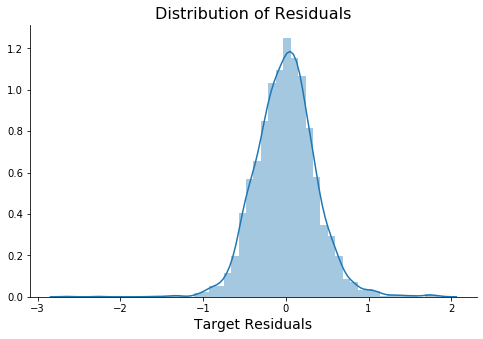

In [20]:
import seaborn as sns

resid_lm = y_train - test_set_pred

plt.figure(figsize=(8, 5))
sns.distplot(resid_lm)
plt.xlabel('Target Residuals', size=14)
sns.despine()
plt.title('Distribution of Residuals', size=16)
# plt.savefig('img/resid_dist.png')

In [ ]:
# #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
# sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#                  .stack()
#                  .sort_values(ascending=False))
# #first element of sol series is the pair with the bigest correlation
# #https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# sol

In [27]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train.values, y_train.values)
# Get predictions
training_preds_xgb = xgb.predict(X_train.values)
val_preds_xgb = xgb.predict(X_train.values)

[10:18:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


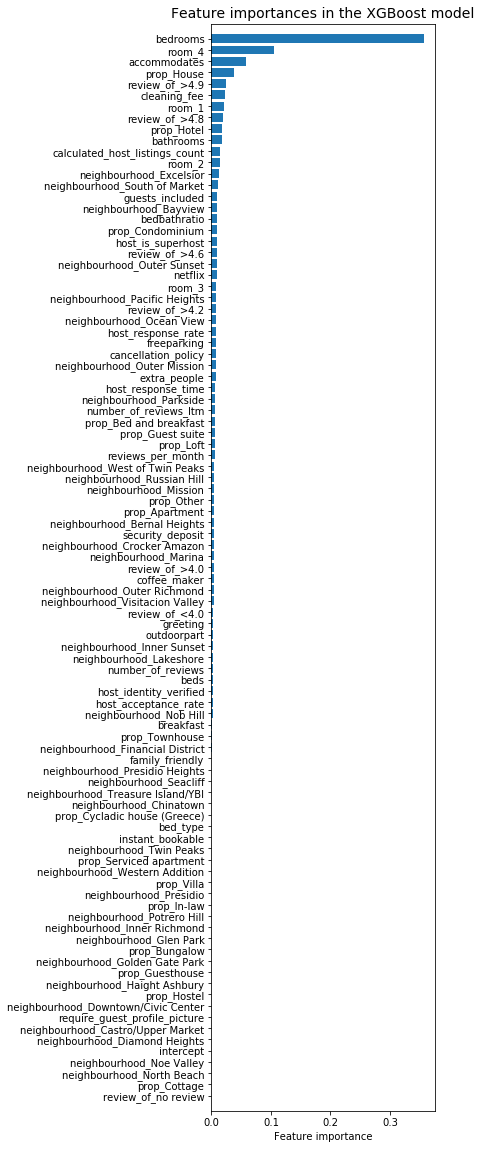

In [29]:
# Producing a dataframe of feature importances
ft_weights_xgb = pd.DataFrame(xgb.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(4,20))
plt.barh(ft_weights_xgb.index, ft_weights_xgb.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()